<a href="https://colab.research.google.com/github/pinkittys/assignment/blob/main/06_Clustering_shared.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
import numpy as np # 수치연산 관련 패키지
import pandas as pd # DataFrame을 다루는 데이터 전처리 패키지
from scipy import stats # statistics tools
import statsmodels.api as sm # linear models
import matplotlib.pyplot as plt # 기본 시각화 패키지
import seaborn as sns # 고급(?) 시각화 패키지 - R의 ggplot 같은겁니다.

# Seaborn 시각화 환경 세팅
sns.set_theme(style='white',
              rc = {'axes.unicode_minus': False,
                    'axes.spines.top':False,
                    'axes.spines.right':False,
                    'axes.titlesize':13,
                    'axes.titleweight':'semibold',
                    'font.family':'DejaVu Sans', #폰트이름 (ex. AppleGothic)
                    'font.weight':'normal'})
sns.despine(left=True, bottom=True)
sns.set_palette('tab10')

<Figure size 640x480 with 0 Axes>

In [28]:
## factor_analyzer 패키지 설치
!pip install factor_analyzer
from factor_analyzer import FactorAnalyzer as FA
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo

In [29]:
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

In [30]:
## 데이터 불러오기
hoteldf = pd.read_csv('/content/cluster_analysis.csv')

In [31]:
hoteldf = hoteldf.rename({'Vacation.':'VacationMoney'}, axis=1) #axis=0 for index and 1 for column, default is 0
hoteldf.head(5)

,Visit,Income,TravelAttitude,VacationImp,HHSize,HHHeadAge,VacationMoney
0,1,50.2,5,8,3,43,2
1,1,70.3,6,7,4,61,3
2,1,62.9,7,5,6,52,3
3,1,48.5,7,5,5,36,1
4,1,52.7,6,6,4,55,3


In [32]:
## 데이터 스케일 표준화
from sklearn.preprocessing import minmax_scale #0-1 표준화
schoteldf = pd.DataFrame(minmax_scale(hoteldf), columns=hoteldf.columns).drop('Visit', axis=1)
schoteldf.head(5)

,Income,TravelAttitude,VacationImp,HHSize,HHHeadAge,VacationMoney
0,0.421911,0.571429,1.000000,0.2,0.21875,0.5
1,0.890443,0.714286,0.857143,0.4,0.78125,1.0
2,0.717949,0.857143,0.571429,0.8,0.50000,1.0
3,0.382284,0.857143,0.571429,0.6,0.00000,0.0
4,0.480186,0.714286,0.714286,0.4,0.59375,1.0


                  Income  TravelAttitude  VacationImp    HHSize  HHHeadAge  \
Income          1.000000        0.401835     0.365402  0.451367   0.120004   
TravelAttitude  0.401835        1.000000     0.165760  0.169329  -0.127321   
VacationImp     0.365402        0.165760     1.000000  0.221544   0.142331   
HHSize          0.451367        0.169329     0.221544  1.000000   0.056692   
HHHeadAge       0.120004       -0.127321     0.142331  0.056692   1.000000   
VacationMoney   0.814274        0.424614     0.282858  0.284497   0.232574   

                VacationMoney  
Income               0.814274  
TravelAttitude       0.424614  
VacationImp          0.282858  
HHSize               0.284497  
HHHeadAge            0.232574  
VacationMoney        1.000000  


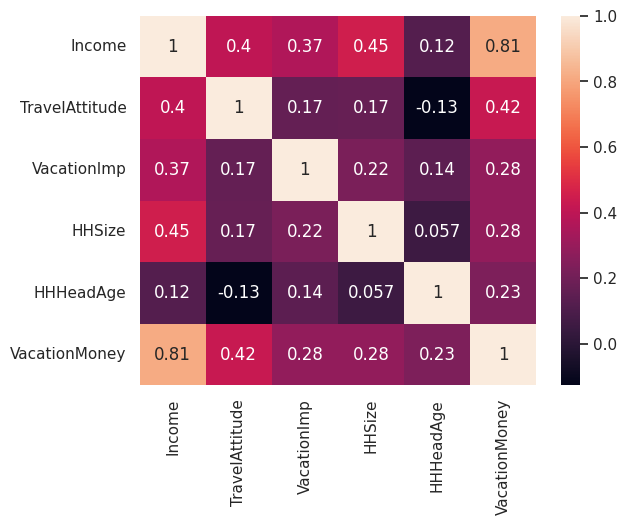

In [33]:
## 상관관계 보여주는 히트맵
corrMatrix = schoteldf.corr()
print(corrMatrix)
sns.heatmap(corrMatrix, annot=True)
plt.show()

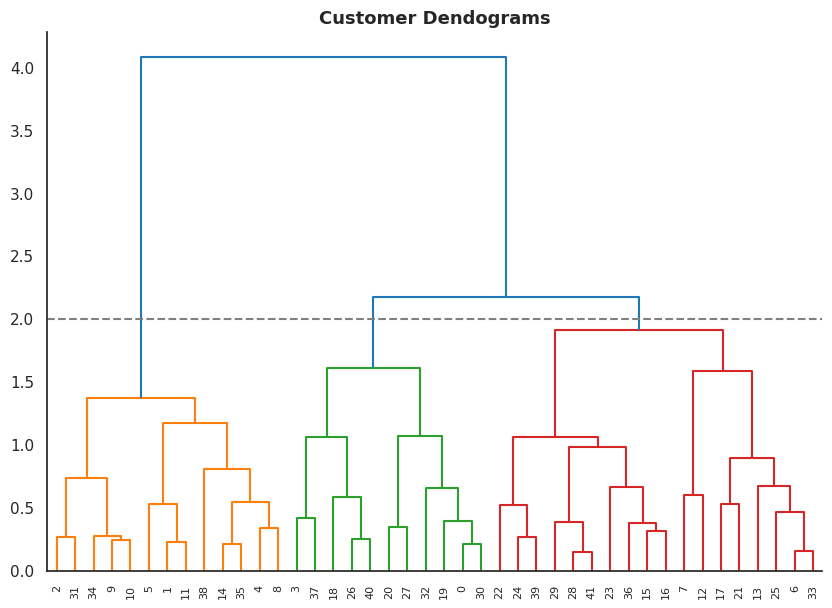

In [34]:
## Step 1: Plot the dendrogram
## 계층적 cluster analysis 실행하기
plt.figure(figsize=(10, 7))
plt.title("Customer Dendograms")
dendrogram = shc.dendrogram(shc.linkage(schoteldf, method='ward'),
                      color_threshold=2) #determines the actual number of clusters
plt.axhline(y=2, linestyle='--', color='gray') #determines the horizontal line in the dendrogram
plt.show()

In [35]:
# Step 1: Compute the linkage matrix
linkage_matrix = shc.linkage(schoteldf, method='ward')

# Step 2: Extract the distances at which clusters are merged
# The distances are the last column of the linkage matrix
merge_distances = linkage_matrix[:, 2]

In [36]:
linkage_matrix

array([[28.        , 41.        ,  0.14714269,  2.        ],
       [ 6.        , 33.        ,  0.15841985,  2.        ],
       [14.        , 35.        ,  0.20955115,  2.        ],
       [ 0.        , 30.        ,  0.21193911,  2.        ],
       [ 1.        , 11.        ,  0.22582379,  2.        ],
       [ 9.        , 10.        ,  0.23886354,  2.        ],
       [26.        , 40.        ,  0.25452055,  2.        ],
       [24.        , 39.        ,  0.26314659,  2.        ],
       [ 2.        , 31.        ,  0.26355924,  2.        ],
       [34.        , 47.        ,  0.27449465,  3.        ],
       [15.        , 16.        ,  0.31422798,  2.        ],
       [ 4.        ,  8.        ,  0.33961342,  2.        ],
       [20.        , 27.        ,  0.34509813,  2.        ],
       [36.        , 52.        ,  0.37718284,  3.        ],
       [29.        , 42.        ,  0.38856536,  3.        ],
       [19.        , 45.        ,  0.3966508 ,  3.        ],
       [ 3.        , 37.

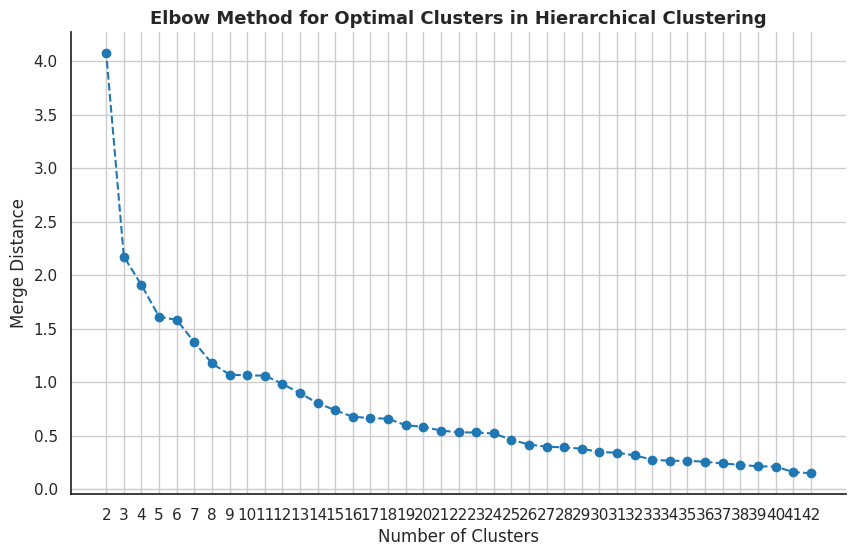

In [37]:
# Step 3: Compute the number of clusters for each merge step
# The number of clusters is simply the reverse of the merge step index
num_clusters = range(len(merge_distances) + 1, 1, -1)

# Step 4: Plot the Elbow Method
plt.figure(figsize=(10, 6))
plt.plot(num_clusters, merge_distances, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal Clusters in Hierarchical Clustering')
plt.xlabel('Number of Clusters')
plt.ylabel('Merge Distance')
plt.xticks(num_clusters)
plt.grid(True)
plt.show()

In [38]:
## cluster analysis 멤버십 배정하기
clusterdf = pd.DataFrame(zip(dendrogram['leaves'], dendrogram['leaves_color_list']), columns=['index', 'cluster'])
clusterdf = clusterdf.sort_values('index').reset_index(drop=True)
clusterdf

,index,cluster
0,0,C2
1,1,C1
2,2,C1
3,3,C2
4,4,C1
5,5,C1
6,6,C3
7,7,C3
8,8,C1
9,9,C1


In [39]:
## 각 segment 이해하기
## hierarchy group별로 분포 분석하기
hoteldf['hierarchy_cluster'] = clusterdf['cluster']
hoteldf.groupby('hierarchy_cluster').mean()

,Visit,Income,TravelAttitude,VacationImp,HHSize,HHHeadAge,VacationMoney
hierarchy_cluster,,,,,,,
C1,0.923077,64.115385,6.230769,6.000000,4.461538,54.230769,3.000000
C2,0.363636,48.254545,5.909091,5.272727,3.272727,42.545455,1.636364
C3,0.277778,42.744444,3.277778,3.777778,3.444444,54.388889,1.500000


In [40]:
hoteldf.head()

,Visit,Income,TravelAttitude,VacationImp,HHSize,HHHeadAge,VacationMoney,hierarchy_cluster
0,1,50.2,5,8,3,43,2,C2
1,1,70.3,6,7,4,61,3,C1
2,1,62.9,7,5,6,52,3,C1
3,1,48.5,7,5,5,36,1,C2
4,1,52.7,6,6,4,55,3,C1


- C1 = (high income) senior luxury travelers
- C2 = (middle (low) income) young & economical travelers
- C3 = non-travlers

-> 누구를 타겟팅 해야할까?

In [41]:
# 시각화
print('Kaiser-Meyer-Olkin(KMO) Test :', calculate_kmo(schoteldf)[1]) # recommended to be above .6
print('Bartlett’s test p-value :', calculate_bartlett_sphericity(schoteldf)[1]) # should be rejected

Kaiser-Meyer-Olkin(KMO) Test : 0.6239331249616269
Bartlett’s test p-value : 3.3383423610217273e-09


/usr/local/lib/python3.10/dist-packages/factor_analyzer/utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


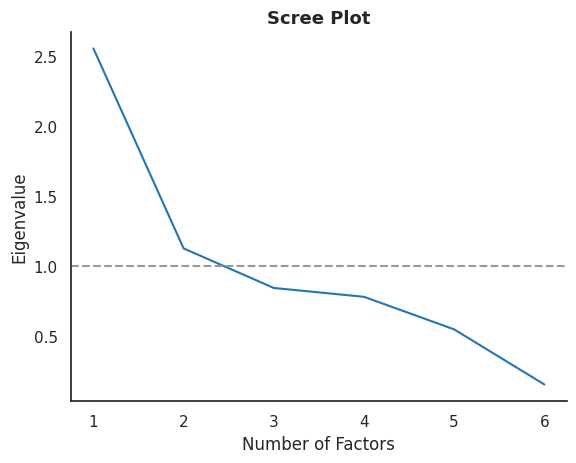

In [42]:
fa = FA(n_factors=5, rotation=None)
fa.fit(schoteldf)
ev, v = fa.get_eigenvalues()

fig = sns.lineplot(x=range(1, len(ev)+1), y=ev)
fig.set(title='Scree Plot', xlabel='Number of Factors', ylabel='Eigenvalue')
plt.axhline(1, color=[.6,.6,.6], linestyle='--')
plt.show()

In [43]:
var_fa = FA(n_factors=2, rotation='varimax')
var_fa.fit(schoteldf)

variancedf = pd.DataFrame(var_fa.get_factor_variance())
variancedf.columns = 'Factor #'+pd.Series(variancedf.columns).astype(str)
variancedf.index = ['SS Loadings', 'Proportion Var', 'Cumulative Var']

loadingsdf = pd.DataFrame(var_fa.loadings_)
loadingsdf.columns = 'Factor #'+pd.Series(loadingsdf.columns).astype(str)
loadingsdf.index = schoteldf.columns
loadingsdf

,Factor #0,Factor #1
Income,0.975619,0.058159
TravelAttitude,0.469747,-0.154481
VacationImp,0.369584,0.110119
HHSize,0.419734,0.028951
HHHeadAge,0.073490,0.996604
VacationMoney,0.816783,0.157601


In [44]:
fa_scores = pd.DataFrame(var_fa.transform(schoteldf))
fa_scores.columns = ['WTP for travels','Age of household head']
print(fa_scores)

    WTP for travels  Age of household head
0          0.043716              -1.049518
1          1.546563               1.121422
2          1.026667              -0.001306
3         -0.096220              -1.797167
4          0.246366               0.362909
5          1.932310               2.007956
6         -0.401487               1.360873
7          0.302622              -0.049242
8          1.122319               0.636738
9          1.476494              -0.874080
10         1.847560              -1.008234
11         1.620543               1.484414
12         0.227711               0.289397
13        -0.122716               0.507940
14         0.917575               0.751570
15        -1.497150               0.946993
16        -1.211712               0.582206
17        -0.690487               0.704906
18         0.011049              -1.761155
19        -0.387813              -1.158832
20        -0.890922              -0.676624
21         0.121564               0.731199
22        -

In [52]:
# fa_scores를 hoteldf에 병합하여 hoteldf_fa 생성
hoteldf_fa = pd.concat([hoteldf, fa_scores], axis=1)

In [53]:
# 지금 이 코드에서는 이중 for문 사용해서 프로그래밍 안 익숙한 분들은 좀 헷갈릴 수 있습니다.
for factor_name in loadingsdf.columns :
    list_factorweight = []
    for variable, weight in loadingsdf[factor_name].to_dict().items() : # ex. (Afford, -0.66)
        list_factorweight.append(hoteldf[variable]*weight)
    hoteldf[factor_name] = np.sum(list_factorweight, axis=0)

In [54]:
print(hoteldf_fa.columns)

Index(['Visit', 'Income', 'TravelAttitude', 'VacationImp', 'HHSize',
       'HHHeadAge', 'VacationMoney', 'hierarchy_cluster', 'Factor #0',
       'Factor #1', 'WTP for travels', 'Age of household head'],
      dtype='object')


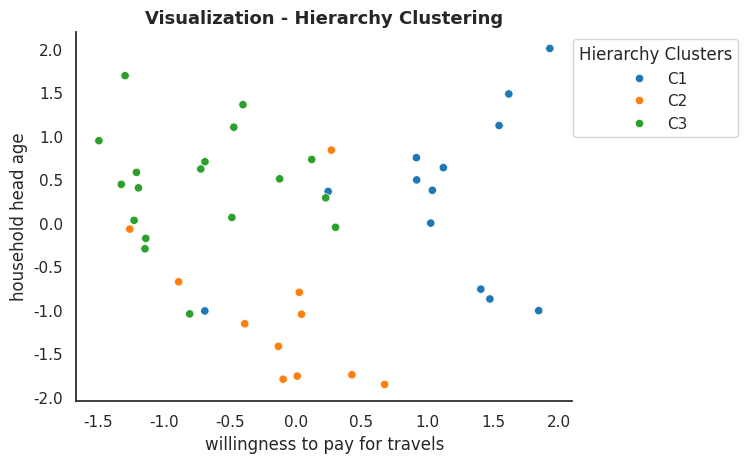

In [55]:
# Hierarchical Clustering
fig = sns.scatterplot(x='WTP for travels', y='Age of household head', hue='hierarchy_cluster',
                      hue_order=['C1','C2','C3'],
                      palette=sns.color_palette()[:3],
                      data = hoteldf_fa)
fig.set(title='Visualization - Hierarchy Clustering')
plt.xlabel('willingness to pay for travels')
plt.ylabel('household head age')
fig.legend(title='Hierarchy Clusters', loc='upper right', bbox_to_anchor=(1.35,1))
plt.show()
